In [1]:
# Installation des pycoSHARKs
import sys
# !{sys.executable} -m pip install pycoshark
# !{sys.executable} -m pip install scikit-learn


In [2]:
# Data Manipulation
from mongoengine import connect, disconnect
from pycoshark.mongomodels import File, FileAction, Commit, Project, VCSSystem, IssueSystem,Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message
from pycoshark.utils import create_mongodb_uri_string
import pandas as pd
import numpy as np

# DataViz
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import mean_squared_error 
from math import sqrt

# Database credentials
user = 'grundlagenki2021'
password = '38BTGx71d'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
connect(database, host=uri)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

C:\Users\Paul\AppData\Local\Temp\ipykernel_7580\747591074.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [3]:
def getreport(projectnames):
    projectdf = []
    for items in (projectnames):
        
    # We first need the the project from the database
        project = Project.objects(name=items).get()
        issue_tracker = IssueSystem.objects(project_id=project.id).get()
        dfin = pd.read_json(Issue.objects(issue_system_id=issue_tracker.id).to_json())
        extid = issue_tracker.url.rsplit('=', 1)[1] # obtain the correct external_id for each repository to sort out invalid issues or logs
        dfin = dfin[dfin.external_id.str.startswith(extid)]#print(projectdf)
        print('read'+str(items))
        projectdf.append(dfin)
        print(len(projectdf))
    #print(projectdf[0])    
    df1 = pd.concat(projectdf)   
    print(df1.shape)    
    df = df1
    
    df['created_at'] = pd.json_normalize(df['created_at'])
    df['updated_at'] = pd.json_normalize(df['updated_at'])
    df['timetofix'] = (df.updated_at-df.created_at)/(100*60*60*24*30.41)
    df=df[df.timetofix>0].copy()
    # df['status'] = df['status'].replace('Closed', 1)
    # df['status'] = df['status'].replace('In Progress', 0)
    # df['status'] = df['status'].replace('Open', 0)
    # df['status'] = df['status'].replace('Resolved', 1)
    # df['status'] = df['status'].replace('Reopened', 0)
    # df['status'] = df['status'].replace('Patch Available', 0)
    df['status'] = np.where((((df['status'] == 'Closed')|(df['status'] == 'Resolved')) & (df['timetofix'] < 6)),  1,0)
  
    #df=df[['external_id', 'creator_id', 'issue_type', 'priority', 'status' , 'timetofix']]
    df = df[[ 'creator_id', 'issue_type', 'priority', 'status', 'timetofix']]
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=['priority', 'issue_type'])
    
    return(df)

projects = ['calcite', 'pig', 'kylin', 'cayenne', 'falcon', 'uima-ducc',]
df = getreport(projects)

readcalcite
1
readpig
2
readkylin
3
readcayenne
4
readfalcon
5
readuima-ducc
6
(19685, 25)


In [4]:
#df
#sns.pairplot(df, y_vars=['status'])
#df.head()
#df.corr().style.background_gradient(cmap='coolwarm')

In [5]:
# Entfernen von Außreisern
#time_25 = df.describe().T.loc['timetofix', '25%']
#time_75 = df.describe().T.loc['timetofix', '75%']

#IQR_time = 1.5 * (time_75 - time_25)

#df = df.query(' timetofix >= (@time_25 - @IQR_time) & timetofix <= (@time_75 + @IQR_time) ')

# Zu berücksichtigende Merkmale und gesuchte Daten wählen
y_class = df.status
x_class = df.drop(columns=['creator_id','timetofix','status'])

# In Training- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.3) # 70% training and 30% test

In [6]:
old_acc = 0
opt_k = 0
for k in range(50):
    k = k+1
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test) 
    if old_acc < metrics.accuracy_score(y_test, y_pred):
        old_acc = metrics.accuracy_score(y_test, y_pred)
        opt_k = k
    #print(k,metrics.accuracy_score(y_test, y_pred))
print(opt_k)

6


In [7]:
knn = KNeighborsClassifier(n_neighbors = opt_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test) 

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

performance = pd.DataFrame({ 'True Value': y_test, 'Prediction': y_pred, 'Error': y_test - y_pred})
#performance

Accuracy: 0.8011353556856484


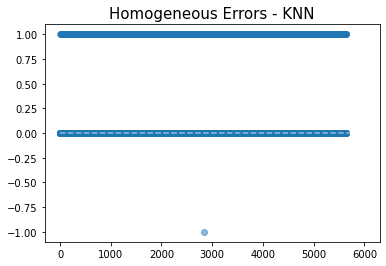

In [8]:
plt.figure()
# Errors
ax_x = performance['True Value']
ax_y = performance['Prediction']
yerr = performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - KNN', size=15)
plt.hlines(y=0, xmin=0, xmax=6000, linestyle='--', color='white', alpha=.5)

((array([-3.66647956, -3.43301454, -3.30443342, ...,  3.30443342,
          3.43301454,  3.66647956]),
  array([-1,  0,  0, ...,  1,  1,  1])),
 (0.2797305598701468, 0.19850984566258648, 0.7000931005440246))

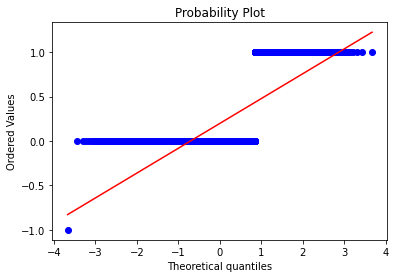

In [9]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt)

[[4514    1]
 [1120    2]]


Text(0.5, 103.73999999999997, 'Predicted label')

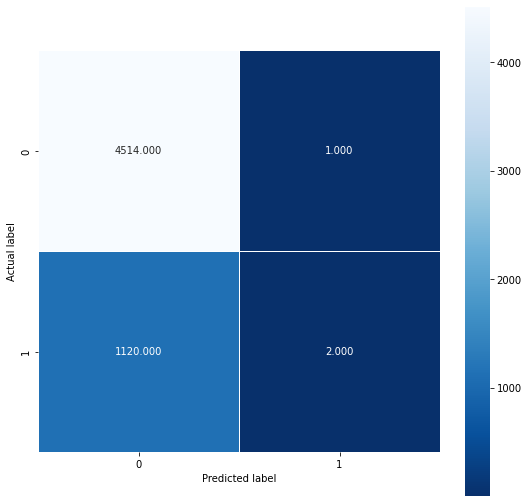

In [10]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
